In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
os.chdir("..")
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from utils.script_utils import obtain_data, obtain_data_cval
from utils.train_script import use_ml_models, use_dl

from derma.sol.stratification.utils.utils import (
                    stratify_survival_prediction, plot_mean_survival_curves, 
                    plot_calibration_curve, plot_calibration_curve, plot_calibration_curve_km,
                    plot_time_auc, plot_survival_roc_curve)
from derma.sol.stratification.utils.calibration import survival_probability_calibration

<frozen importlib._bootstrap>:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [2]:
_,_,data, labels = obtain_data_cval(dl=False)
_,_, data_dl, labels_dl = obtain_data_cval(dl=True)

deep_copy_data= copy.deepcopy(data)
data_dh= copy.deepcopy(data)
labels_dh = copy.deepcopy(labels_dl)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

### Train models

In [3]:
### Create hyperparams
class ArgsDict:
    def __init__(self, params_dict):
        self.params_dict = params_dict
        
    def __getattr__(self, name):
        if name in self.params_dict:
            return self.params_dict[name]
        else:
            raise AttributeError(f"'ArgsDict' object has no attribute '{name}'")
            
args_rsf = {
    "min_child_weight": 1,    "num_boost_round": 100,
    "gamma": 0.001,    "alpha": 0.0001,
    "n_estimators": 400,    "max_depth": 11,
    "min_samples_split": 25,    "max_features": "auto",
    "model": "rsf"
}


args_ds = {
    "dropout_prob": 0.1, "lr": 0.0001, "reg": 0.001,    "num_durations": 30,
    "num_layers": 5,    "num_nodes": 16,
    "batch_norm": True,    "output_bias": True,
    "model": "deepsurv", "verbose" : False
}

args_dh = {
    "dropout_prob": 0.1, "lr": 0.0001, "reg": 0.001,    "num_durations": 30,
    "num_layers": 6,    "num_nodes": 16,
    "batch_norm": True,    "output_bias": True,
    "model": "deephit", "verbose" : False
}



# Obtain "ArgParser"
args_rsf = ArgsDict(args_rsf)
args_ds = ArgsDict(args_ds)
args_dh = ArgsDict(args_dh)

In [4]:
# Train deepsurv model
rsf_cindex, rsf_brier, rsf_model = use_ml_models(data, labels, args_rsf)

In [5]:
# Train the DeepSurv model
ds_cindex, ds_brier, log_ds, ds_model = use_dl(data_dl, labels_dl, args_ds)

Could not log loss


In [6]:
# Train the DeepHit model
dh_cindex, dh_brier, log_dh, dh_model = use_dl(data_dh, labels_dh, args_dh)

IndexError: list index out of range

0.6754590049872862

/home/carlos.hernandez/PhD/marato-derma/derma/sol/stratification/utils/calibration.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/carlos.hernandez/dl/lib/python3.8/site-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with CRCSplineFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/home/carlos.hernandez/PhD/marato-derma/derma/sol/stratification/utils/calibration.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


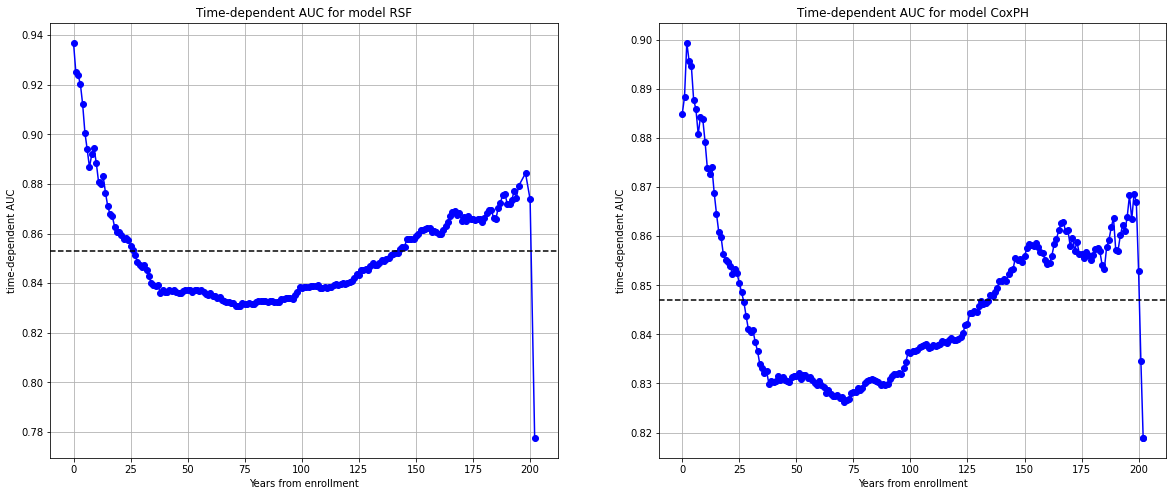

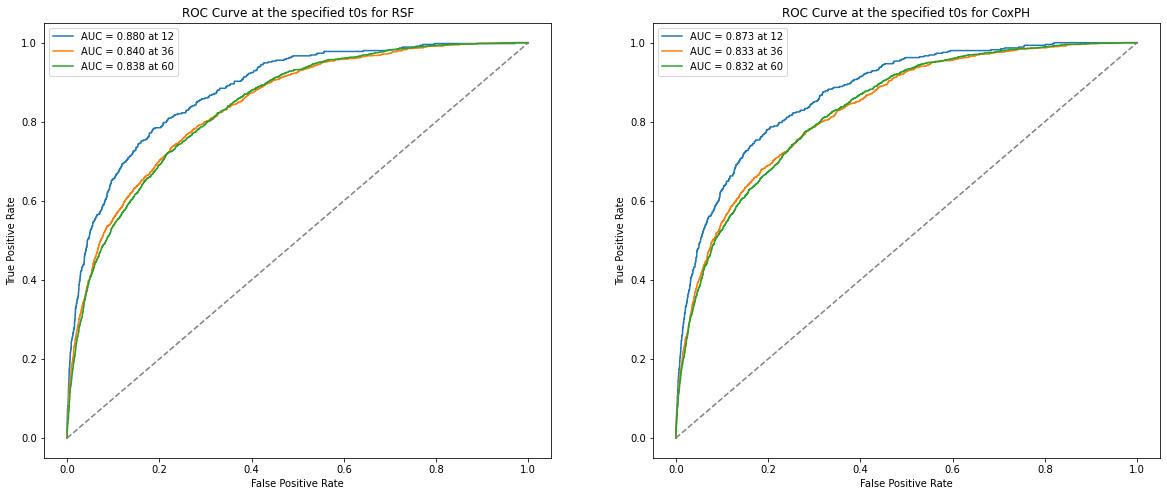

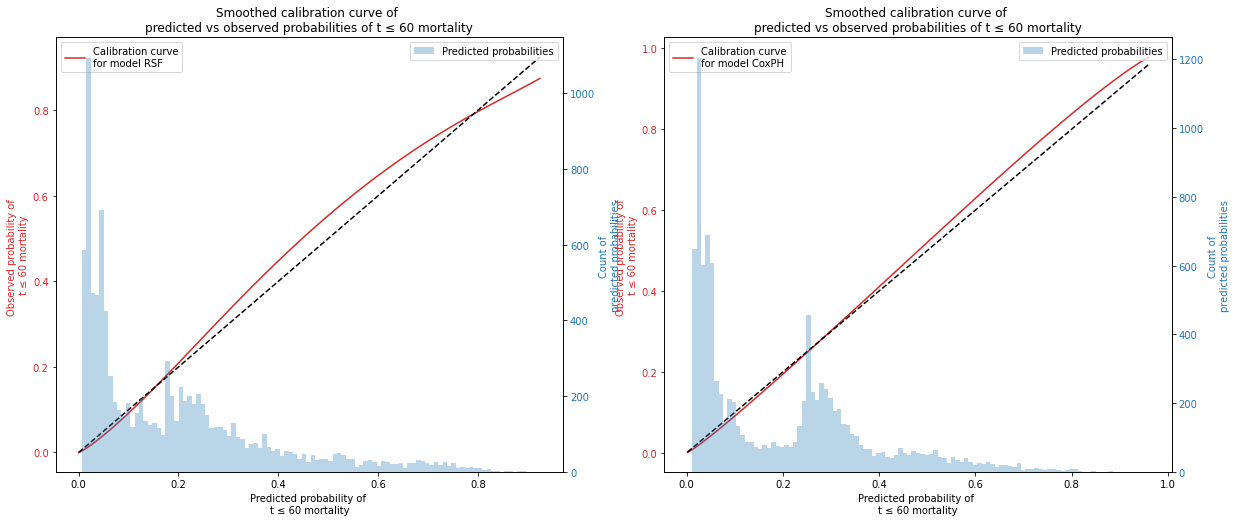

In [8]:
#deep_copy_data = copy.deepcopy(data)
train_times = [x[1] for x in labels[0]]
train_events = [x[0] for x in labels[0]]

test_times = [x[1] for x in labels[1]]
test_events = [x[0] for x in labels[1]]


train_df = pd.DataFrame({'event': train_events, 'duration': train_times})
test_df = pd.DataFrame({'event': test_events, 'duration': test_times})



fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), gridspec_kw={'hspace': 0.5})
fig_2, axs_2 = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), gridspec_kw={'hspace': 0.5})
fig_3, axs_3 = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), gridspec_kw={'hspace': 0.5, 'wspace': 0.2})

X_train = deep_copy_data[0]
X_test = deep_copy_data[1]


for i, model in enumerate([rsf_model, ds_model]):
    ax = axs[i]
    ax_2 = axs_2[i]
    ax_3 = axs_3[i]
    plot_time_auc(model, X_test, train_df, test_df, ax=ax)
    plot_survival_roc_curve(model, X_test, test_df, times_plot = [12,12*3,12*5], ax=ax_2)
    #plot_calibration_curve(model, X_test, test_df, [5], ax=ax_3)
    _ = survival_probability_calibration(model, X_test, test_df, 60, ax=ax_3)

In [11]:
ds_cindex

0.7969388323919993